In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit nicer
plt.rcParams["figure.figsize"] = (10, 4)

# Class ID → Annotation mapping (from brief)
id_to_label = {
    0: "Undetermined",
    1: "N",   # Normal
    2: "L",   # LBBB
    3: "R",   # RBBB
    4: "V",   # Premature ventricular contraction
    5: "A",   # Atrial premature beat
    6: "F",   # Fusion ventricular normal beat
    7: "f",   # Fusion of paced and normal beat
    8: "/",   # Paced beat
}


In [2]:
# CHANGE THESE PATHS / NAMES IF NEEDED
train_path = "train_beats.csv"
test_path  = "test_beats.csv"

train_df = pd.read_csv(train_path, header=None)
test_df  = pd.read_csv(test_path, header=None)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
train_df.head()


Train shape: (30992, 277)
Test shape : (37442, 277)


,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,2.016945,1.344029,1.344029,1.273195,1.344029,1.166946,1.060696,1.025279,1.025279,0.989862,...,0.175280,0.281530,0.210697,0.175280,0.139863,0.281530,0.210697,0.352363,7.0,104.0
1,1.956627,0.034137,0.009170,0.059105,-0.040765,-0.015798,0.034137,0.084072,0.009170,-0.015798,...,-1.014493,-1.014493,-1.014493,-0.989526,-0.914624,-0.964559,-1.014493,-1.089396,2.0,111.0
2,0.435271,0.725131,0.712529,0.750337,0.788144,0.825952,0.863760,0.838555,0.788144,0.762939,...,-0.308283,-0.220065,-0.157051,-0.081436,-0.043628,0.031988,0.120206,0.284040,6.0,208.0
3,0.230134,-0.199004,-0.215509,-0.215509,-0.221011,-0.221011,-0.226513,-0.243018,-0.254022,-0.232015,...,1.016888,1.055400,1.071905,1.060902,1.060902,1.049898,1.055400,1.060902,8.0,107.0
4,3.406234,-0.103728,-0.121545,-0.050277,0.038809,0.110077,0.145711,0.110077,0.110077,0.038809,...,-0.228447,-0.228447,-0.121545,-0.192813,-0.228447,-0.264081,-0.264081,-0.264081,1.0,116.0


In [3]:
# assume: columns [0 : -2] -> ECG signal, column -2 -> label, column -1 -> patient_id
def split_xy(df):
    X = df.iloc[:, :-2].values     # ECG samples
    y = df.iloc[:, -2].values      # class ID
    patient_id = df.iloc[:, -1].values  # patient number
    return X, y, patient_id

X_train, y_train, pid_train = split_xy(train_df)
X_test,  y_test,  pid_test  = split_xy(test_df)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Unique labels in train:", np.unique(y_train))


X_train shape: (30992, 275)
y_train shape: (30992,)
Unique labels in train: [1. 2. 3. 4. 5. 6. 7. 8.]


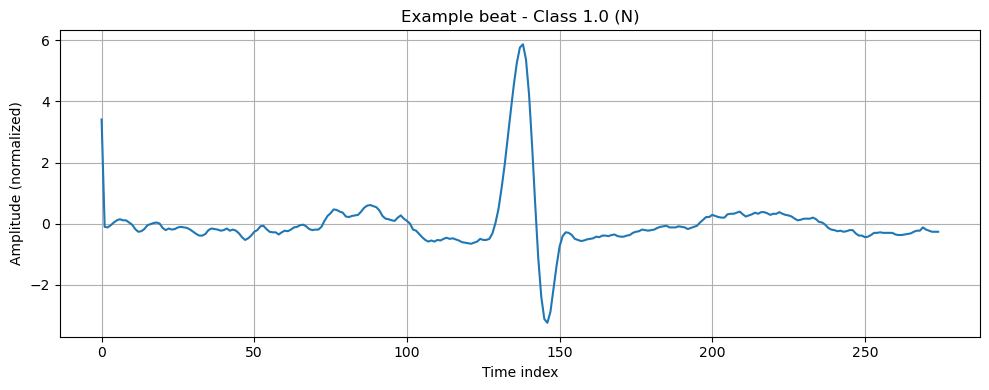

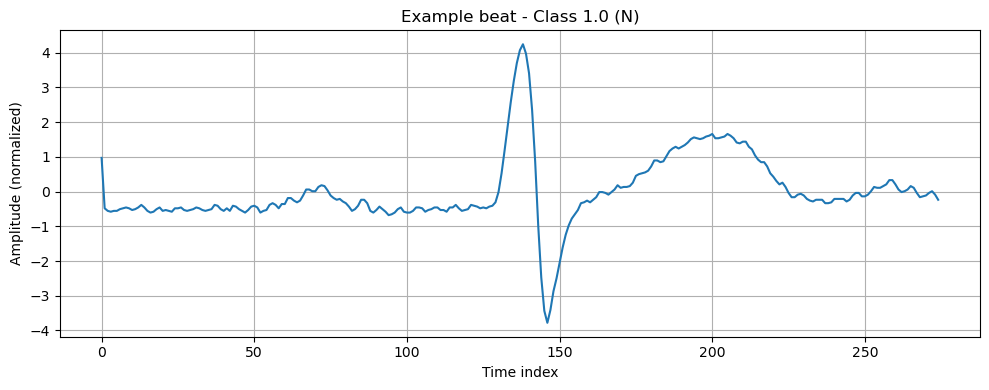

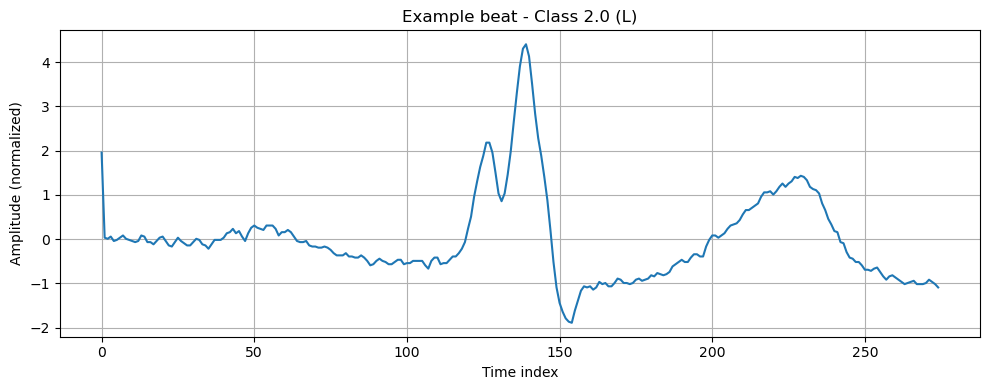

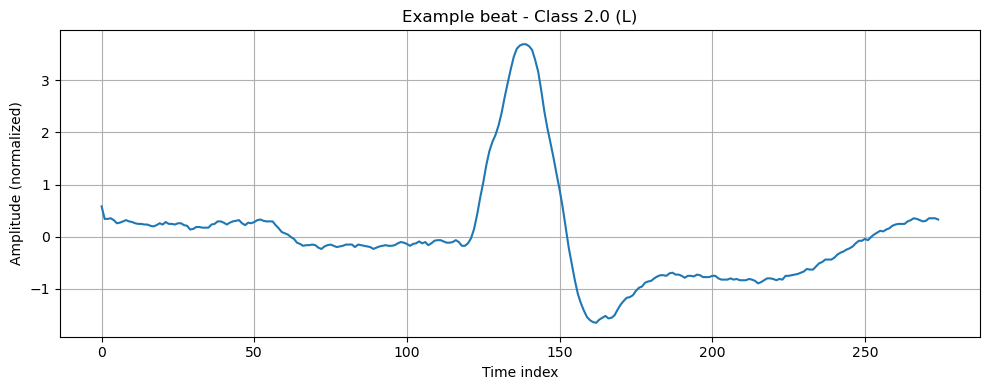

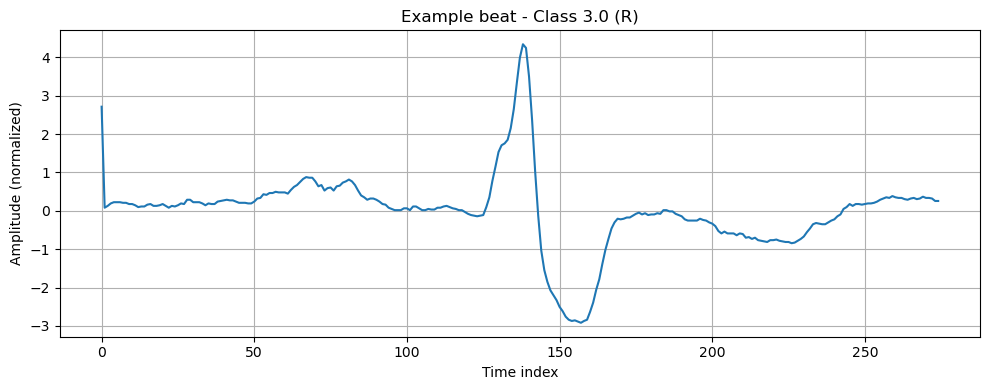

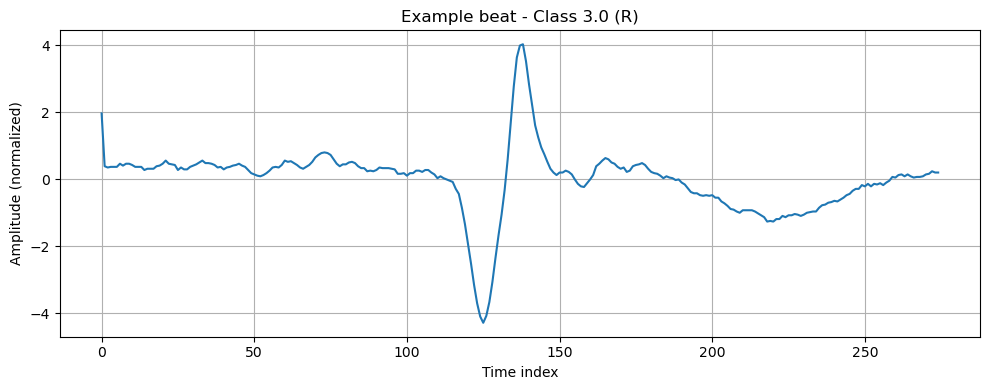

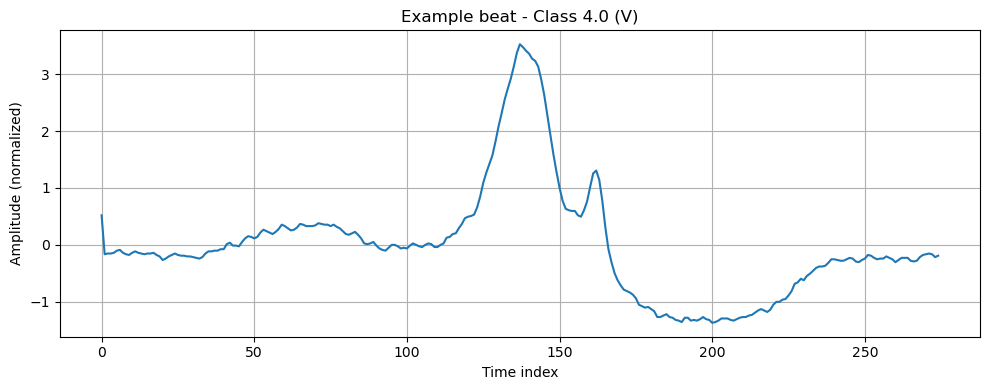

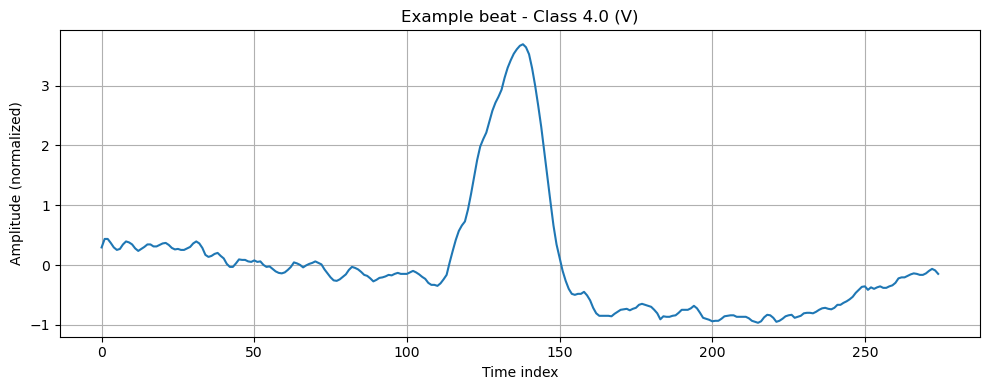

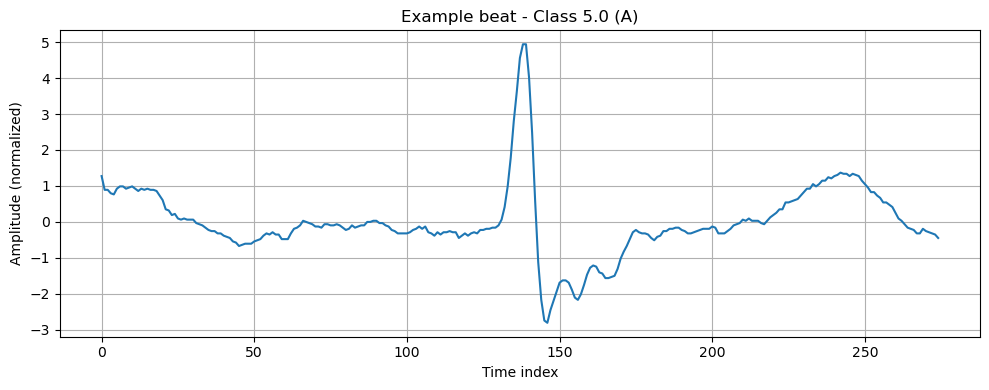

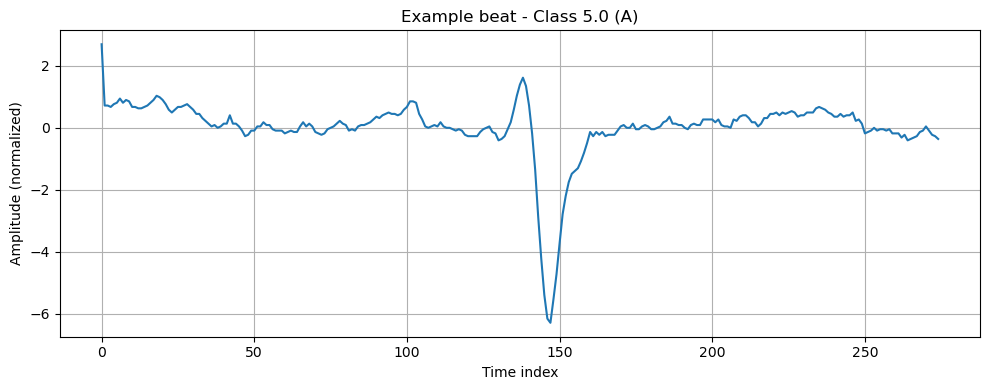

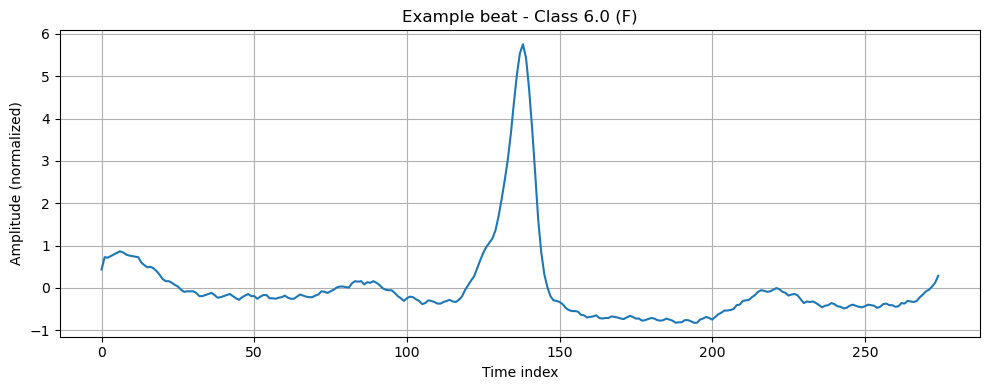

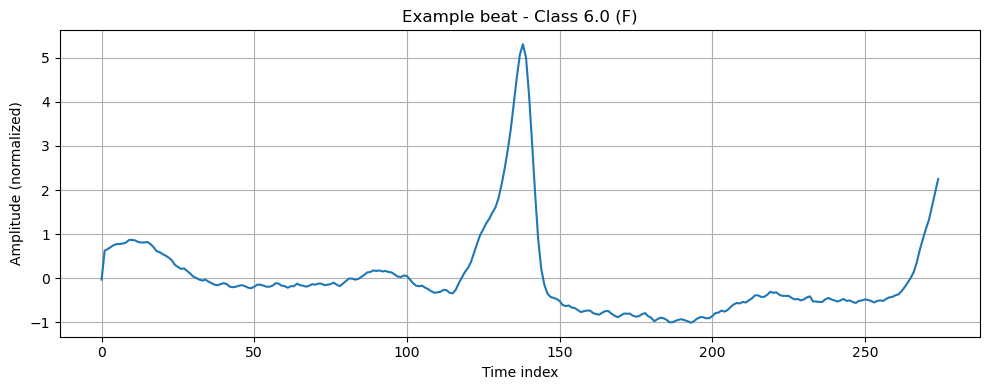

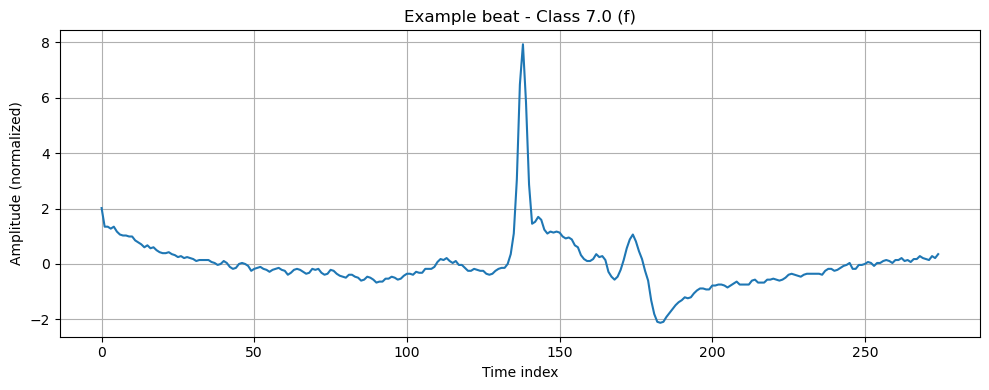

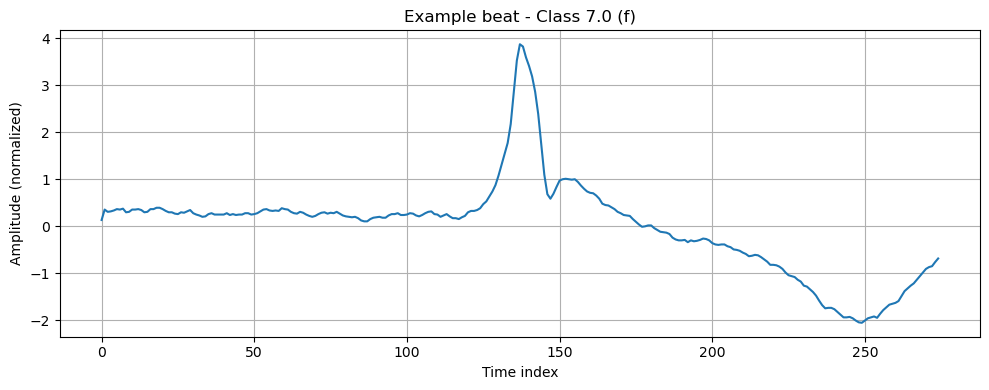

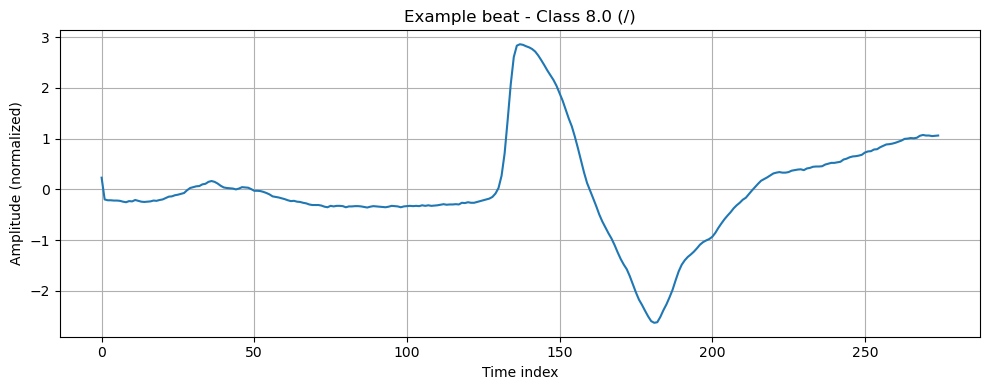

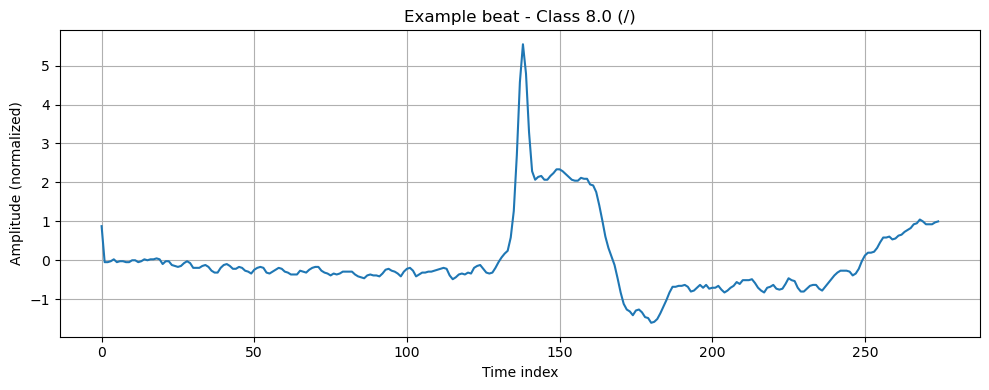

In [4]:
def plot_examples_per_class(X, y, n_per_class=2):
    unique_classes = np.unique(y)
    for cls in unique_classes:
        idx = np.where(y == cls)[0][:n_per_class]
        if len(idx) == 0:
            continue
        
        label_name = id_to_label.get(int(cls), str(cls))
        for i in idx:
            plt.figure()
            plt.plot(X[i])
            plt.title(f"Example beat - Class {cls} ({label_name})")
            plt.xlabel("Time index")
            plt.ylabel("Amplitude (normalized)")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

plot_examples_per_class(X_train, y_train, n_per_class=2)


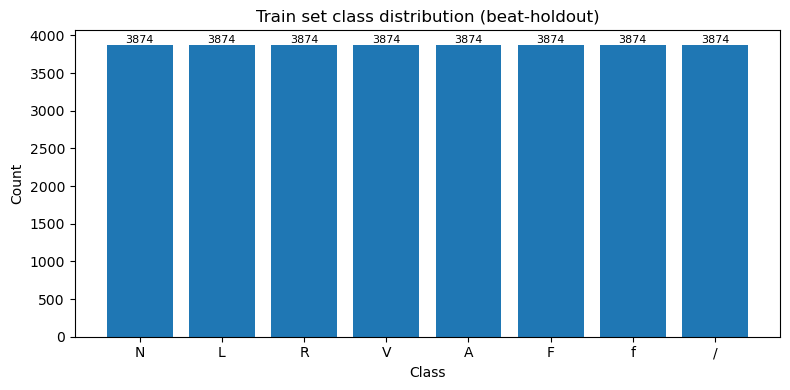

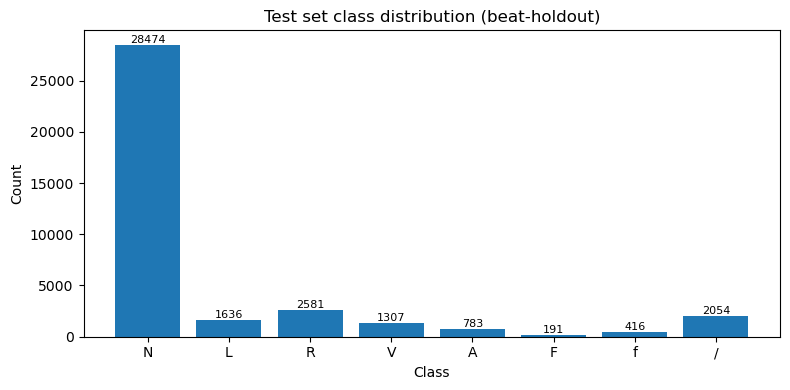

In [5]:
def plot_class_distribution(y, title="Class distribution"):
    labels, counts = np.unique(y, return_counts=True)
    label_names = [id_to_label.get(int(l), str(l)) for l in labels]
    
    plt.figure(figsize=(8,4))
    plt.bar(label_names, counts)
    for i, c in enumerate(counts):
        plt.text(i, c, str(c), ha="center", va="bottom", fontsize=8)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_class_distribution(y_train, "Train set class distribution (beat-holdout)")
plot_class_distribution(y_test,  "Test set class distribution (beat-holdout)")


In [6]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# SVM pipeline: standardize features + RBF SVM
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=1.0, gamma="scale", decision_function_shape="ovr"))
])

# Train on beat-holdout TRAIN set
svm_clf.fit(X_train, y_train)

print("SVM training finished.")


SVM training finished.


In [7]:
# Predict on test set
y_pred = svm_clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (beat-holdout test set): {acc:.4f}")

# Precision, Recall, F1 per class (macro average is best for imbalanced data)
prec, rec, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=np.unique(y_test))

for cls, p, r, f, s in zip(np.unique(y_test), prec, rec, f1, support):
    print(f"Class {int(cls)} -> Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, Support: {s}")

print("\nMacro-averaged metrics:")
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro"
)
print(f"Precision (macro): {prec_macro:.3f}")
print(f"Recall (macro):    {rec_macro:.3f}")
print(f"F1-score (macro):  {f1_macro:.3f}")

# Optional: full sklearn report
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))


Accuracy (beat-holdout test set): 0.9494
Class 1 -> Precision: 0.996, Recall: 0.941, F1: 0.968, Support: 28474
Class 2 -> Precision: 0.990, Recall: 0.996, F1: 0.993, Support: 1636
Class 3 -> Precision: 0.996, Recall: 0.988, F1: 0.992, Support: 2581
Class 4 -> Precision: 0.779, Recall: 0.953, F1: 0.858, Support: 1307
Class 5 -> Precision: 0.568, Recall: 0.911, F1: 0.699, Support: 783
Class 6 -> Precision: 0.200, Recall: 0.937, F1: 0.330, Support: 191
Class 7 -> Precision: 0.733, Recall: 0.942, F1: 0.824, Support: 416
Class 8 -> Precision: 0.993, Recall: 0.992, F1: 0.992, Support: 2054

Macro-averaged metrics:
Precision (macro): 0.782
Recall (macro):    0.958
F1-score (macro):  0.832

Classification report:

              precision    recall  f1-score   support

         1.0       1.00      0.94      0.97     28474
         2.0       0.99      1.00      0.99      1636
         3.0       1.00      0.99      0.99      2581
         4.0       0.78      0.95      0.86      1307
         5.0 

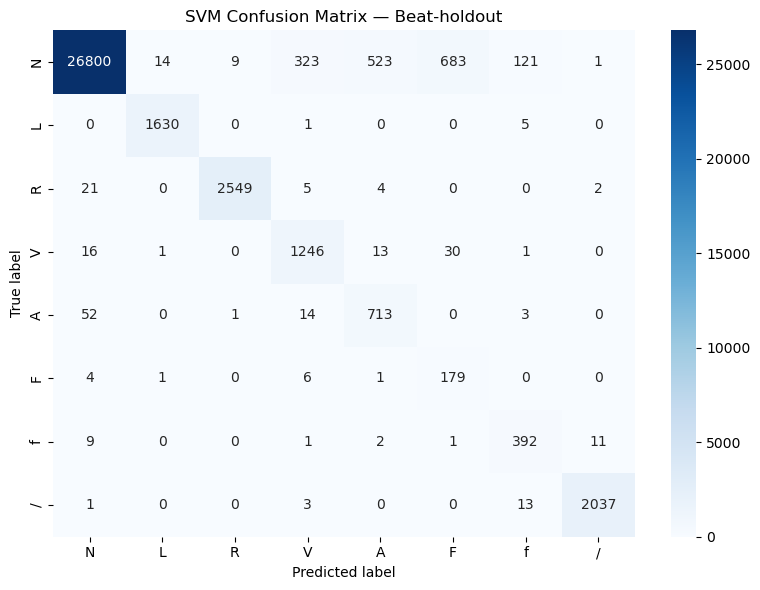

In [8]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Map IDs to labels (reuse your id_to_label dict)
labels = np.unique(y_test)
tick_labels = [id_to_label[int(l)] for l in labels]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=tick_labels, yticklabels=tick_labels,
            cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("SVM Confusion Matrix — Beat-holdout")
plt.tight_layout()
plt.show()


In [9]:
# ---- STEP 3: SVM with patient-holdout split ----

patient_train_path = "train_patients.csv"   # change to your actual file name
patient_test_path  = "test_patients.csv"    # change to your actual file name

patient_train_df = pd.read_csv(patient_train_path, header=None)
patient_test_df  = pd.read_csv(patient_test_path, header=None)

print("Patient-holdout Train shape:", patient_train_df.shape)
print("Patient-holdout Test shape :", patient_test_df.shape)
patient_train_df.head()


Patient-holdout Train shape: (35384, 277)
Patient-holdout Test shape : (14482, 277)


,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,-3.371279,-0.237666,0.209993,-0.088447,-0.685325,-0.536106,-0.386886,-0.088447,0.060773,-0.386886,...,0.060773,-0.386886,-0.386886,-0.088447,0.209993,-0.237666,0.060773,-0.536106,4.0,200.0
1,-0.109315,-0.546804,-0.421807,-0.234312,0.015681,0.078180,0.140678,-0.109315,0.078180,0.390672,...,0.578167,0.515668,0.703163,0.515668,0.453170,0.515668,0.640665,0.765662,1.0,221.0
2,-0.016025,1.356476,0.881665,0.540394,0.295570,0.162029,0.095259,0.073002,0.043326,0.013651,...,0.087840,0.073002,0.073002,0.080421,0.080421,0.073002,0.073002,0.065583,4.0,233.0
3,0.102569,0.346993,0.395878,0.346993,0.314404,0.298109,0.330698,0.346993,0.412173,0.379583,...,0.607713,0.591418,0.607713,0.624008,0.672892,0.721777,0.705482,0.689187,7.0,217.0
4,1.604485,-0.699510,-0.644653,-0.480082,-0.516653,-0.498368,-0.516653,-0.589796,-0.553225,-0.626368,...,-0.443511,-0.553225,-0.553225,-0.571510,-0.717796,-0.754367,-0.845796,-0.864081,1.0,117.0


In [10]:
X_train_p, y_train_p, pid_train_p = split_xy(patient_train_df)
X_test_p,  y_test_p,  pid_test_p  = split_xy(patient_test_df)

print("X_train_p shape:", X_train_p.shape)
print("y_train_p shape:", y_train_p.shape)
print("Unique labels in patient-train:", np.unique(y_train_p))
print("Unique labels in patient-test :", np.unique(y_test_p))


X_train_p shape: (35384, 275)
y_train_p shape: (35384,)
Unique labels in patient-train: [1. 2. 3. 4. 5. 6. 7. 8.]
Unique labels in patient-test : [1. 4. 6. 7. 8.]


In [11]:
svm_clf_patient = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=1.0, gamma="scale", decision_function_shape="ovr"))
])

svm_clf_patient.fit(X_train_p, y_train_p)
print("SVM (patient-holdout) training finished.")


SVM (patient-holdout) training finished.


In [12]:
y_pred_p = svm_clf_patient.predict(X_test_p)

acc_p = accuracy_score(y_test_p, y_pred_p)
print(f"Accuracy (patient-holdout test set): {acc_p:.4f}")

prec_p, rec_p, f1_p, support_p = precision_recall_fscore_support(
    y_test_p, y_pred_p, labels=np.unique(y_test_p)
)

for cls, p, r, f, s in zip(np.unique(y_test_p), prec_p, rec_p, f1_p, support_p):
    print(f"Class {int(cls)} -> Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, Support: {s}")

print("\nMacro-averaged metrics (patient-holdout):")
prec_macro_p, rec_macro_p, f1_macro_p, _ = precision_recall_fscore_support(
    y_test_p, y_pred_p, average="macro"
)
print(f"Precision (macro): {prec_macro_p:.3f}")
print(f"Recall (macro):    {rec_macro_p:.3f}")
print(f"F1-score (macro):  {f1_macro_p:.3f}")

print("\nClassification report (patient-holdout):\n")
print(classification_report(y_test_p, y_pred_p))


Accuracy (patient-holdout test set): 0.8659
Class 1 -> Precision: 0.955, Recall: 0.931, F1: 0.942, Support: 9363
Class 4 -> Precision: 0.655, Recall: 0.975, F1: 0.783, Support: 1087
Class 6 -> Precision: 0.751, Recall: 0.452, F1: 0.565, Support: 387
Class 7 -> Precision: 0.910, Recall: 0.125, F1: 0.219, Support: 1138
Class 8 -> Precision: 0.945, Recall: 0.977, F1: 0.961, Support: 2507

Macro-averaged metrics (patient-holdout):
Precision (macro): 0.527
Recall (macro):    0.432
F1-score (macro):  0.434

Classification report (patient-holdout):

              precision    recall  f1-score   support

         1.0       0.95      0.93      0.94      9363
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.65      0.98      0.78      1087
         5.0       0.00      0.00      0.00         0
         6.0       0.75      0.45      0.56       387
         7.0       0.91      0.12      0.22      1138
         8.0      

m:\anaconda\envs\genv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
m:\anaconda\envs\genv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
m:\anaconda\envs\genv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
m:\anaconda\envs\genv\Lib\site-packages\sklearn\metrics\_clas

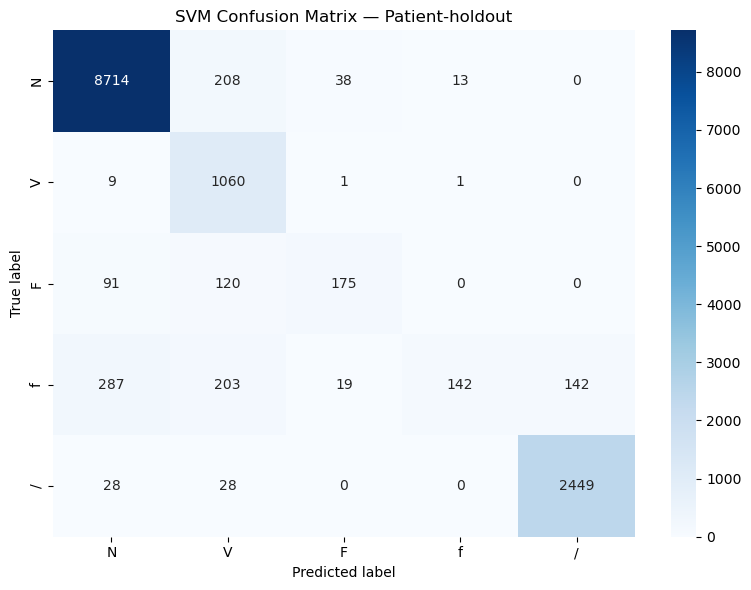

In [13]:
cm_p = confusion_matrix(y_test_p, y_pred_p, labels=np.unique(y_test_p))

labels_p = np.unique(y_test_p)
tick_labels_p = [id_to_label[int(l)] for l in labels_p]

plt.figure(figsize=(8,6))
sns.heatmap(cm_p, annot=True, fmt="d",
            xticklabels=tick_labels_p, yticklabels=tick_labels_p,
            cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("SVM Confusion Matrix — Patient-holdout")
plt.tight_layout()
plt.show()


In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def get_slice_indices(n_features=275, n_slices=11):
    """Return list of (start, end) indices for each slice."""
    slice_size = n_features // n_slices  # 275 // 11 = 25
    indices = []
    for s in range(n_slices):
        start = s * slice_size
        end = (s + 1) * slice_size   # end is exclusive
        indices.append((start, end))
    return indices

slice_indices = get_slice_indices(275, 11)
slice_indices


[(0, 25),
 (25, 50),
 (50, 75),
 (75, 100),
 (100, 125),
 (125, 150),
 (150, 175),
 (175, 200),
 (200, 225),
 (225, 250),
 (250, 275)]

In [15]:
def pfi_slices_svm(
    X, y,
    n_slices=11,
    n_splits=3,
    random_state=42,
    max_samples=None
):
    """
    Permutation Feature Importance using 11 slices and Stratified K-fold CV.
    Returns: mean importance per slice (length = n_slices).
    """
    rng = np.random.RandomState(random_state)
    
    # Optionally subsample for speed
    if max_samples is not None and X.shape[0] > max_samples:
        from sklearn.utils import resample
        X, y = resample(
            X, y,
            n_samples=max_samples,
            replace=False,
            random_state=random_state
        )
        print(f"Subsampled to {max_samples} samples for PFI.")
    
    n_features = X.shape[1]
    slice_indices = get_slice_indices(n_features, n_slices)
    
    # K-fold CV
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )
    
    # store importance per slice per fold
    importances = np.zeros((n_slices, n_splits))
    
    fold_idx = 0
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        # fresh SVM for each fold
        svm = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(kernel="rbf", C=1.0, gamma="scale", decision_function_shape="ovr"))
        ])
        svm.fit(X_tr, y_tr)
        
        # baseline score
        y_pred_base = svm.predict(X_val)
        base_score = accuracy_score(y_val, y_pred_base)
        
        print(f"Fold {fold_idx+1}/{n_splits} - baseline accuracy: {base_score:.4f}")
        
        # for each slice: permute slice in validation data, measure drop
        for s_idx, (start, end) in enumerate(slice_indices):
            X_val_perm = X_val.copy()
            
            # permute this slice (randomly shuffle rows within slice)
            # we permute *within* the slice across samples
            perm_indices = rng.permutation(X_val_perm.shape[0])
            X_val_perm[:, start:end] = X_val_perm[perm_indices, start:end]
            
            y_pred_perm = svm.predict(X_val_perm)
            perm_score = accuracy_score(y_val, y_pred_perm)
            
            importances[s_idx, fold_idx] = base_score - perm_score
        
        fold_idx += 1
    
    # average over folds
    mean_importance = importances.mean(axis=1)
    return mean_importance


Subsampled to 15000 samples for PFI.
Fold 1/3 - baseline accuracy: 0.9536
Fold 2/3 - baseline accuracy: 0.9508
Fold 3/3 - baseline accuracy: 0.9528
Beat-holdout slice importances:
 [0.0612     0.05193333 0.077      0.12293333 0.08406667 0.1638
 0.17093333 0.12       0.0954     0.09326667 0.04493333]


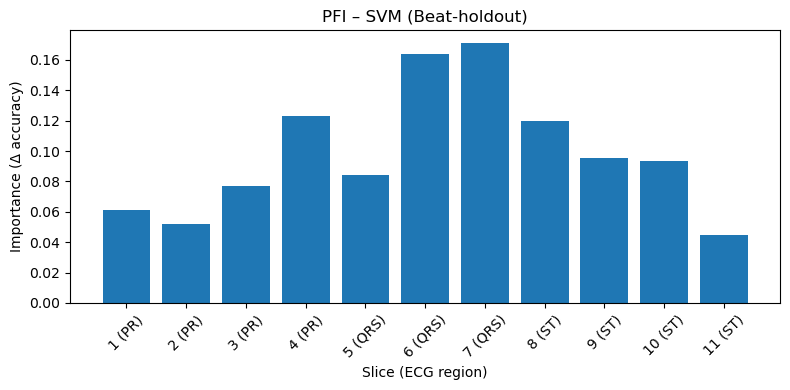

In [16]:
# ---- PFI for beat-holdout SVM ----

pfi_beat = pfi_slices_svm(
    X_train, y_train,
    n_slices=11,
    n_splits=3,      # change to 5 if you have time
    max_samples=15000   # reduce or increase depending on your machine
)

print("Beat-holdout slice importances:\n", pfi_beat)
# Map slices to ECG segments (as in slides)
slice_labels = [
    "1 (PR)", "2 (PR)", "3 (PR)", "4 (PR)",
    "5 (QRS)", "6 (QRS)", "7 (QRS)",
    "8 (ST)", "9 (ST)", "10 (ST)", "11 (ST)"
]

plt.figure(figsize=(8,4))
plt.bar(range(1, 12), pfi_beat)
plt.xticks(range(1, 12), slice_labels, rotation=45)
plt.xlabel("Slice (ECG region)")
plt.ylabel("Importance (Δ accuracy)")
plt.title("PFI – SVM (Beat-holdout)")
plt.tight_layout()
plt.show()


Subsampled to 15000 samples for PFI.
Fold 1/3 - baseline accuracy: 0.9626
Fold 2/3 - baseline accuracy: 0.9556
Fold 3/3 - baseline accuracy: 0.9632
Patient-holdout slice importances:
 [0.04786667 0.05093333 0.06646667 0.0992     0.09173333 0.153
 0.1434     0.10353333 0.0804     0.07733333 0.05586667]


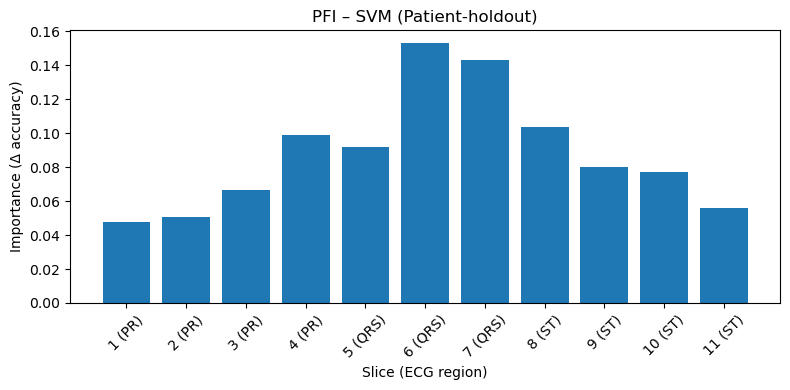

In [17]:
# ---- PFI for patient-holdout SVM ----

pfi_patient = pfi_slices_svm(
    X_train_p, y_train_p,
    n_slices=11,
    n_splits=3,
    max_samples=15000
)

print("Patient-holdout slice importances:\n", pfi_patient)
plt.figure(figsize=(8,4))
plt.bar(range(1, 12), pfi_patient)
plt.xticks(range(1, 12), slice_labels, rotation=45)
plt.xlabel("Slice (ECG region)")
plt.ylabel("Importance (Δ accuracy)")
plt.title("PFI – SVM (Patient-holdout)")
plt.tight_layout()
plt.show()


Decision Tree Accuracy (beat-holdout): 0.8659

Decision Tree classification report (beat-holdout):
              precision    recall  f1-score   support

         1.0       0.99      0.84      0.91     28474
         2.0       0.81      0.98      0.89      1636
         3.0       0.81      0.96      0.88      2581
         4.0       0.55      0.91      0.69      1307
         5.0       0.26      0.80      0.39       783
         6.0       0.24      0.82      0.37       191
         7.0       0.39      0.77      0.52       416
         8.0       0.94      0.98      0.96      2054

    accuracy                           0.87     37442
   macro avg       0.62      0.88      0.70     37442
weighted avg       0.93      0.87      0.89     37442



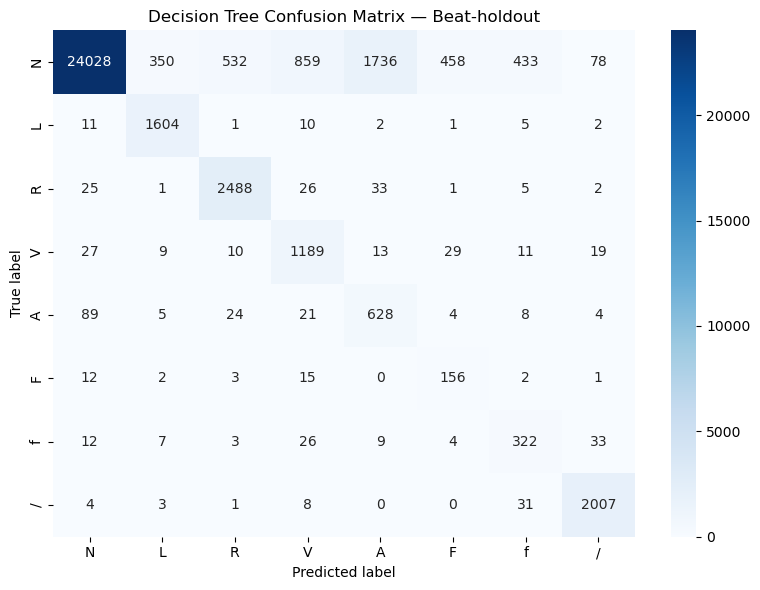

In [18]:
from sklearn.tree import DecisionTreeClassifier

# ---- Decision Tree for beat-holdout ----
dt_beat = DecisionTreeClassifier(
    max_depth=None,          # you can limit e.g. max_depth=20 if overfitting
    min_samples_split=2,
    random_state=42
)

dt_beat.fit(X_train, y_train)
y_pred_dt_beat = dt_beat.predict(X_test)

print(f"Decision Tree Accuracy (beat-holdout): {accuracy_score(y_test, y_pred_dt_beat):.4f}")
print("\nDecision Tree classification report (beat-holdout):")
print(classification_report(y_test, y_pred_dt_beat))

cm_dt_beat = confusion_matrix(y_test, y_pred_dt_beat, labels=np.unique(y_test))
tick_labels = [id_to_label[int(l)] for l in np.unique(y_test)]

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_dt_beat,
    annot=True,
    fmt="d",
    xticklabels=tick_labels,
    yticklabels=tick_labels,
    cmap="Blues"
)
plt.title("Decision Tree Confusion Matrix — Beat-holdout")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


Decision Tree Accuracy (patient-holdout): 0.7534

Decision Tree classification report (patient-holdout):
              precision    recall  f1-score   support

         1.0       0.94      0.83      0.88      9363
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.64      0.80      0.71      1087
         5.0       0.00      0.00      0.00         0
         6.0       0.04      0.01      0.02       387
         7.0       0.30      0.07      0.11      1138
         8.0       0.92      0.86      0.89      2507

    accuracy                           0.75     14482
   macro avg       0.36      0.32      0.33     14482
weighted avg       0.84      0.75      0.79     14482



m:\anaconda\envs\genv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
m:\anaconda\envs\genv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
m:\anaconda\envs\genv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


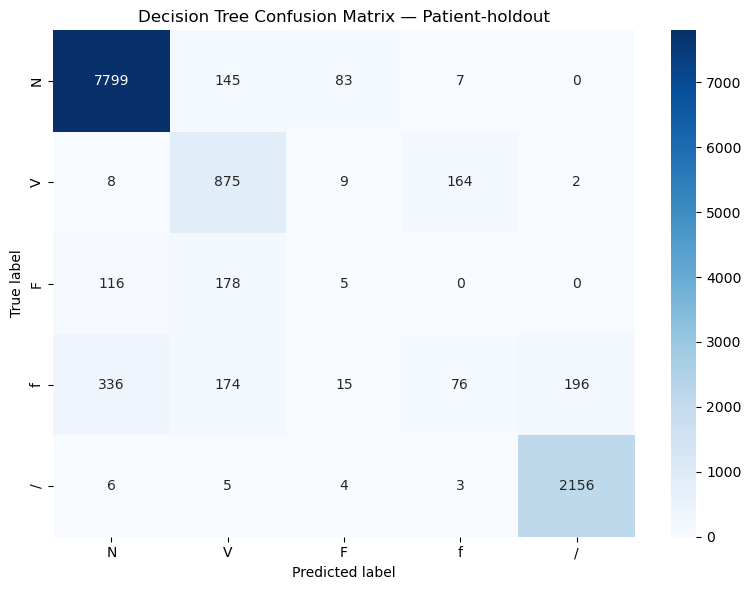

In [19]:
# ---- Decision Tree for patient-holdout ----
dt_patient = DecisionTreeClassifier(
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

dt_patient.fit(X_train_p, y_train_p)
y_pred_dt_p = dt_patient.predict(X_test_p)

print(f"Decision Tree Accuracy (patient-holdout): {accuracy_score(y_test_p, y_pred_dt_p):.4f}")
print("\nDecision Tree classification report (patient-holdout):")
print(classification_report(y_test_p, y_pred_dt_p))

cm_dt_p = confusion_matrix(y_test_p, y_pred_dt_p, labels=np.unique(y_test_p))
tick_labels_p = [id_to_label[int(l)] for l in np.unique(y_test_p)]

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_dt_p,
    annot=True,
    fmt="d",
    xticklabels=tick_labels_p,
    yticklabels=tick_labels_p,
    cmap="Blues"
)
plt.title("Decision Tree Confusion Matrix — Patient-holdout")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


In [20]:
from sklearn.model_selection import StratifiedKFold

def pfi_slices_model(
    X, y, model_builder,
    n_slices=11,
    n_splits=3,
    random_state=42,
    max_samples=None
):
    rng = np.random.RandomState(random_state)

    # optional subsample for speed
    if max_samples is not None and X.shape[0] > max_samples:
        from sklearn.utils import resample
        X, y = resample(
            X, y,
            n_samples=max_samples,
            replace=False,
            random_state=random_state
        )
        print(f"Subsampled to {max_samples} samples for PFI.")

    n_features = X.shape[1]
    slice_indices = get_slice_indices(n_features, n_slices)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    importances = np.zeros((n_slices, n_splits))

    fold_idx = 0
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = model_builder()
        model.fit(X_tr, y_tr)

        base_score = accuracy_score(y_val, model.predict(X_val))

        for s_idx, (start, end) in enumerate(slice_indices):
            X_val_perm = X_val.copy()
            perm_idx = rng.permutation(X_val_perm.shape[0])
            X_val_perm[:, start:end] = X_val_perm[perm_idx, start:end]
            perm_score = accuracy_score(y_val, model.predict(X_val_perm))
            importances[s_idx, fold_idx] = base_score - perm_score

        fold_idx += 1

    return importances.mean(axis=1)


In [21]:
def build_decision_tree():
    return DecisionTreeClassifier(
        max_depth=None,
        min_samples_split=2,
        random_state=42
    )


Subsampled to 15000 samples for PFI.


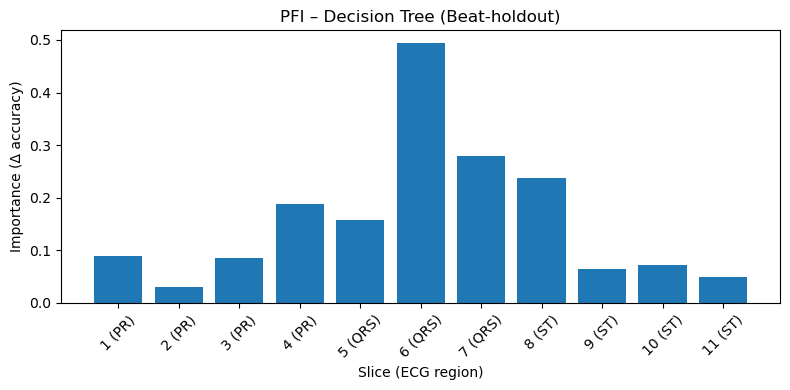

In [22]:
pfi_dt_beat = pfi_slices_model(
    X_train, y_train,
    model_builder=build_decision_tree,
    n_slices=11,
    n_splits=3,
    max_samples=15000   # adjust based on speed
)

plt.figure(figsize=(8,4))
plt.bar(range(1,12), pfi_dt_beat)
plt.xticks(range(1,12), slice_labels, rotation=45)
plt.xlabel("Slice (ECG region)")
plt.ylabel("Importance (Δ accuracy)")
plt.title("PFI – Decision Tree (Beat-holdout)")
plt.tight_layout()
plt.show()


Subsampled to 15000 samples for PFI.


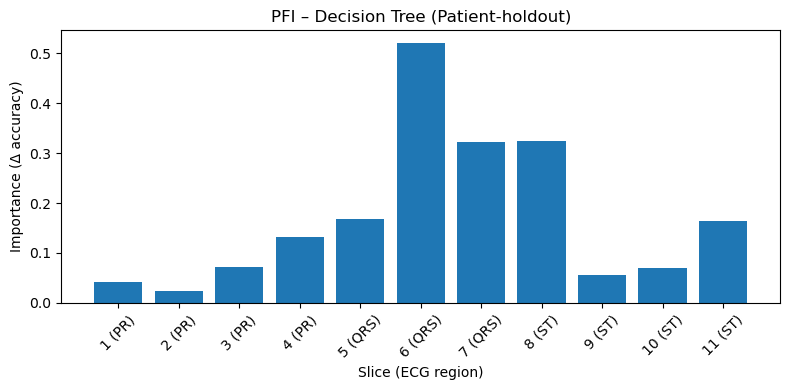

In [23]:
pfi_dt_patient = pfi_slices_model(
    X_train_p, y_train_p,
    model_builder=build_decision_tree,
    n_slices=11,
    n_splits=3,
    max_samples=15000
)

plt.figure(figsize=(8,4))
plt.bar(range(1,12), pfi_dt_patient)
plt.xticks(range(1,12), slice_labels, rotation=45)
plt.xlabel("Slice (ECG region)")
plt.ylabel("Importance (Δ accuracy)")
plt.title("PFI – Decision Tree (Patient-holdout)")
plt.tight_layout()
plt.show()


In [24]:
from sklearn.cluster import KMeans

print("Running k-means clustering (k=8)...")
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_train_p)

print("Clustering completed. Cluster labels assigned.")

Running k-means clustering (k=8)...
Clustering completed. Cluster labels assigned.


We use the patient holdout split to evaluate the model's ability to generalize to new, unseen patients, which is necessary for real-world use. Standard random splitting (beat holdout) causes data leakage because heartbeats from the same patient are highly correlated and visually similar. By isolating specific patients for testing, we prevent the model from memorizing patient-specific patterns and ensure it learns robust featurs of arrhythmia

In [25]:
from scipy.stats import mode
cluster_to_label_map = {}

for i in range(8):
    indices = np.where(cluster_labels == i)[0]
    
    if len(indices) > 0:
        true_labels_in_cluster = y_train_p[indices]
        most_common_label = mode(true_labels_in_cluster, keepdims=True).mode[0]
        cluster_to_label_map[i] = most_common_label
    else:
        cluster_to_label_map[i] = 1.0

print("Mapping found:", cluster_to_label_map)

Mapping found: {0: np.float64(5.0), 1: np.float64(6.0), 2: np.float64(5.0), 3: np.float64(8.0), 4: np.float64(3.0), 5: np.float64(7.0), 6: np.float64(4.0), 7: np.float64(8.0)}


In [26]:
np.unique(list(cluster_to_label_map.values()))

array([3., 4., 5., 6., 7., 8.])

Running TSNE dimensionality reduction...


C:\Users\Gaurav Sidana\AppData\Local\Temp\ipykernel_41576\3830548744.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap= plt.cm.get_cmap('tab10', 8)


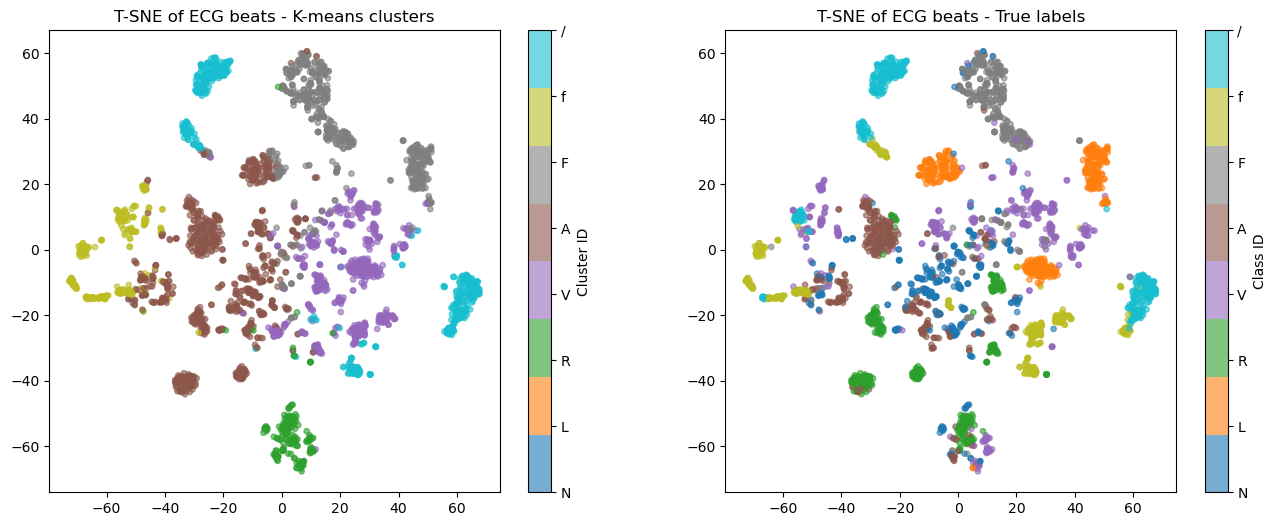

In [28]:
from sklearn.manifold import TSNE

idx_sample = np.random.choice(X_train_p.shape[0], size=3000, replace=False)
X_sample = X_train_p[idx_sample]
y_sample_true = y_train_p[idx_sample]
y_sample_predicted_aligned = np.array([cluster_to_label_map[c] for c in cluster_labels[idx_sample]])

print("Running TSNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_sample)

# Plotting
plt.figure(figsize=(16,6))
vmin, vmax = 1, 8
cmap= plt.cm.get_cmap('tab10', 8)

# colored k-means clusters
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(
    X_embedded[:, 0], X_embedded[:, 1],
    c=y_sample_predicted_aligned,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    s=15,
    alpha=0.6,
)
plt.title("T-SNE of ECG beats - K-means clusters")
cbar1 = plt.colorbar(scatter1, ticks=range(vmin, vmax+1))
cbar1.set_label("Cluster ID")
cbar1.ax.set_yticklabels([id_to_label[i] for i in range(vmin, vmax+1)])

# colored for true labels
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(
    X_embedded[:, 0], X_embedded[:, 1],
    c=y_sample_true,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    s=15,
    alpha=0.6
)
plt.title("T-SNE of ECG beats - True labels")
cbar2 = plt.colorbar(scatter2, ticks=range(vmin, vmax+1))
cbar2.set_label("Class ID")
cbar2.ax.set_yticklabels([id_to_label[i] for i in range(vmin, vmax+1)])

plt.show()

K-means clustering divides ECG beats into 8 clusters based on their features, mapping each cluster to the most common true label within it. While the clusters show reasonable alignment with true labels, some overlap or ambiguity exists in the feature space. T-SNE visualization provides a 2D representation of the high-dimensional data, highlighting areas of alignment and misclassification between clusters and true labels. Although K-means captures meaningful patterns, overlapping classes in the T-SNE space suggest challenges in achieving perfect separation due to feature similarities or algorithm limitations.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

test_cluster_ids = kmeans.predict(X_test_p)

y_pred_cluster = np.array([cluster_to_label_map[c] for c in test_cluster_ids])
acc_cluster = accuracy_score(y_test_p, y_pred_cluster)

print("---Cluster-based classification results---")
print(f"Accuracy: {acc_cluster:.4f}")
print("\nClassification report:\n")
print(classification_report(y_test_p, y_pred_cluster))

---cluster-based classification results---
Accuracy: 0.2181

Classification report:

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      9363
         3.0       0.00      0.00      0.00         0
         4.0       0.24      0.58      0.34      1087
         5.0       0.00      0.00      0.00         0
         6.0       0.06      0.30      0.10       387
         7.0       0.00      0.00      0.00      1138
         8.0       0.76      0.96      0.85      2507

    accuracy                           0.22     14482
   macro avg       0.15      0.26      0.18     14482
weighted avg       0.15      0.22      0.18     14482



m:\anaconda\envs\genv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
m:\anaconda\envs\genv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
m:\anaconda\envs\genv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
m:\anaconda\envs\genv\Lib\site-packages\sklea

Based on the K-means clustering results with majority vote mapping, paced beats (/) achieve the highest performance (96% recall, 85% F1-score) because their artificial, device-generated morphology creates clear seperation from natural cardiac rhythm in the feature space. In contrast, 
classes like Normal (N), LBBB (L), RBBB (R), and fusion beats (f) show zero performance, indicating their morphological features overlap significantly and don't form the distinct, spherical clusters that K-means requires. The overall 22% accuracy demonstrates that while K-means successfully identifies highly distinctive arrhythmias like paced beats, it struggles with the subtle, continuous variations in natural cardiac rhythms where supervised methods like SVM and Decision Trees would excel.